In [1]:
from udma import UDMA_CLASS as udma
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
# from nistrng import *

ImportError: cannot import name 'int' from 'numpy' (/usr/local/lib/python3.8/dist-packages/numpy/__init__.py)

In [ ]:
#Load Comblock
cb=udma("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [ ]:
# Write init values in fifo:
## Clean fifo taking offset into account
cb.write_reg(37 -16, 1) 
cb.write_reg(37 -16, 0)

## Loading initial values into fifo_out
# fifo_init=np.array(range(1000))%2
fifo_init=np.full(1000,0)
print(cb.write_fifo(len(fifo_init),fifo_init))

## Enable load values
cb.write_reg(4, 1)
sleep(1)
cb.write_reg(4,0)

[(1, 1000), 0]


[(1, 0), 0]

In [ ]:
## Selecting the rule
rule=2845481637

cb.write_reg(9, 0) #Test disable
cb.write_reg(6, 0) #Stop FIFO
cb.write_reg(8, rule) #Set rule
cb.write_reg(0,6) #Set feedback type
cb.write_reg(1,0) #Set to asynchronous
cb.write_reg(2,0) #Change 'clear' value to 0
cb.write_reg(3,0) #Change 'set' value to 0

#Reset cell array
cb.write_reg(5,1)
cb.write_reg(5,0)

#Disable fifo write
cb.write_reg(6,0)

#Select xor mode 1 to xor output, 0 to raw data.
cb.write_reg(12, 0)

#Setting clock divider
cb.write_reg(10, 100)
cb.write_reg(11, 1)
cb.write_reg(11, 0)

#Clear fifo input
cb.write_reg(33 - 16, 1) 
cb.write_reg(33 - 16, 0)

[(1, 0), 0]

In [ ]:
cb.read_reg(34)[1][0]>>16

0

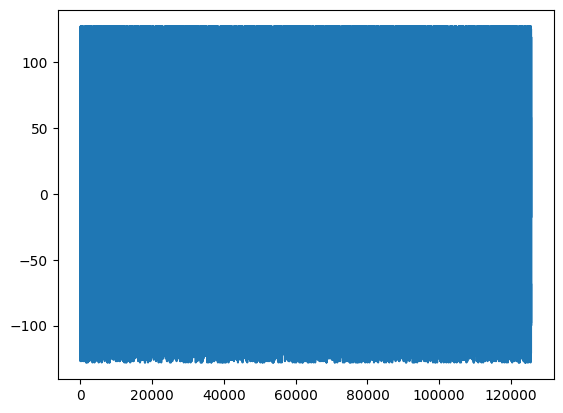

In [ ]:
#Read fifo
N=int(1000000/8)
b=cb.write_reg(6,1)
data=[]
while len(data)<N:
    a=cb.read_fifo(1000)
    data.extend(a[1])
cb.write_reg(6,0)

dsplit=[]
for d in data:
    dsplit.append(d&0xff)
    # dsplit.append((d>>8)&0xff)
    # dsplit.append((d>>16)&0xff)
    # dsplit.append((d>>24)&0xff)

seq: np.ndarray = np.array(dsplit).astype(np.int8)

plt.plot(seq)

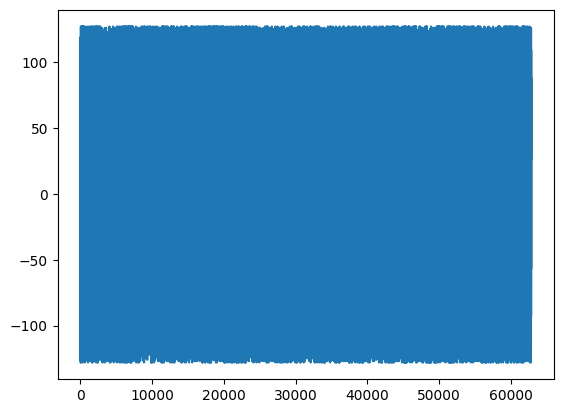

In [ ]:
#Inverting half of the sequence
seq1=seq[:int(len(seq)/2)]
seq2=np.bitwise_not(seq[int(len(seq)/2):])

sequence=seq1+seq2
plt.plot(sequence)

In [ ]:
# Random number generated sequence
# sequence: np.ndarray = np.random.randint(-128, 128, 1000, dtype=int)

# Packing sequence into binary
binary_sequence: np.ndarray = pack_sequence(sequence)
# Print sequence
print("CAA Generated sequence generated by np:")
print(sequence)
print("Random sequence generated by np encoded in 8-bit signed format:")
print(binary_sequence)
print("Original sequence taken back by unpacking (to check the correctness of packing process:")
print(unpack_sequence(binary_sequence))
# Check the eligibility of the test and generate an eligible battery from the default NIST-sp800-22r1a battery
eligible_battery: dict = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)
# Print the eligible tests
print("Eligible test from NIST-SP800-22r1a:")
for name in eligible_battery.keys():
    print("-" + name)
# Test the sequence on the eligible tests
results = run_all_battery(binary_sequence, eligible_battery, False)
# Print results one by one
print("Test results:")
for result, elapsed_time in results:
    if result.passed:
        print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
    else:
        print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

CAA Generated sequence generated by np:
[ 40 101  57 ...  -6 109  27]
Random sequence generated by np encoded in 8-bit signed format:
[0 0 1 ... 0 1 1]
Original sequence taken back by unpacking (to check the correctness of packing process:
[ 40 101  57 ...  -6 109  27]
Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-maurers_universal
-serial
-approximate_entropy
-cumulative sums
-random_excursion
-random_excursion_variant
Test results:
- FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
- FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
- PASSED - score: 0.262 - Longest Run Ones In A Block - elapsed time: 7 ms
- PASSED - score: 0.156 - Binary Matrix Rank - elapsed time: 1734 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 95 ms
- PASSED - score: 0.305 - Non Overlapping Template Matching - elapsed time: 1022 ms
- PASSED - score: 0.02 - M